# **Crop classification by Coconuts**

In the hackathon, we have 3 mains approach.


1.   Relevent indexs using Classical Machine Learning
2.   Image from each band using Deep Learning



In [ ]:
import os
import numpy as np

From [a paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9564343), there are 3 indexs used for crop classification whcih: NDVI, NDWI and EVI.


1.   **NDVI**
* NDVI = -1 to 0 represent Water bodies
* NDVI = -0.1 to 0.1 represent Barren rocks, sand, or snow
* NDVI = 0.2 to 0.5 represent Shrubs and grasslands or senescing crops
* NDVI = 0.6 to 1.0 represent Dense vegetation or tropical rainforest
2.   **NDWI**
3.   **EVI**

In [37]:
import mlflow

mlflow.sklearn.autolog()

# Create dataset

In [38]:
LABELS = ['Cassava', 'Rice', 'Maize', 'Sugarcane']

In [39]:
ROOT_DIR = os.path.abspath('../..')
PROCESSED_DIR = os.path.join(ROOT_DIR, 'data', 'processed')

data_files = os.listdir(PROCESSED_DIR)

data_files

['.DS_Store',
 'ndvi_feature_2D_20211222.pkl',
 'ndwi_feature_2D_20211127.pkl',
 'ndwi_feature_2D_20211222.pkl',
 'ndvi_feature_2D_20211127.pkl',
 'ndvi_feature_2D_20210620.pkl',
 'ndwi_feature_2D_20210327.pkl',
 'ndvi_feature_2D_20210327.pkl',
 'ndwi_feature_2D_20210620.pkl']

In [40]:
import geopandas

gorund_truth = geopandas.read_file(
    os.path.join(ROOT_DIR, 'data', 'raw', 'training_area', 'traindata.shp')
)

labels = gorund_truth['crop_type'].values

len(labels), labels

(1317, array(['1', '1', '1', ..., '1', '3', '3'], dtype=object))

In [41]:
data = []

for idx, file in enumerate(data_files):
    if file == '.DS_Store':
        continue
    sub_data = np.load(os.path.join(PROCESSED_DIR, file), allow_pickle=True)
    if len(data) == 0:
        data = sub_data
    else:
        data = np.concatenate((data, sub_data), axis=1)

    print(data.shape)

data = np.array(data)    

(1317, 6400)
(1317, 12800)
(1317, 19200)
(1317, 25600)
(1317, 32000)
(1317, 38400)
(1317, 44800)
(1317, 51200)


## Train-Test Split

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, stratify=labels, test_size=0.15, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1119, 51200), (198, 51200), (1119,), (198,))

In [43]:
np.min(X_train), np.max(X_train), np.mean(X_train)

(-0.8295015942272194, 0.9176470588235294, 0.0016863934053793724)

# Scaler data

In [44]:
# Minmax scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [45]:
minmax_scaler = MinMaxScaler()
# std_scaler = StandardScaler()

minmax_scaler.fit(X_train)

X_train_scale = minmax_scaler.transform(X_train)
X_test_scale = minmax_scaler.transform(X_test)

In [46]:
np.min(X_train_scale), np.max(X_train_scale)

(0.0, 1.0000000000000002)

# Model

In [47]:
from sklearn.metrics import plot_confusion_matrix

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# RandomForest Classifier

In [53]:
rf_cls = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

with mlflow.start_run(run_name='Random Forest'):
    rf_cls.fit(X_train_scale, y_train)
    metrics = mlflow.sklearn.eval_and_log_metrics(rf_cls, X_test_scale, y_test, prefix="val_")

In [50]:
rf_cls.score(X_test_scale, y_test)

0.601010101010101

/Users/namirinz/opt/anaconda3/envs/geography/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


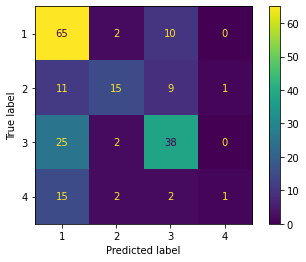

In [51]:
plot_confusion_matrix(rf_cls, X_test_scale, y_test);

# XGBoost

In [54]:
from xgboost import XGBClassifier

In [57]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=10, random_state=42, nthread=-1)

with mlflow.start_run(run_name='XGBoost Classifier'):
    xgb_clf.fit(X_train_scale, y_train)
    metrics = mlflow.sklearn.eval_and_log_metrics(xgb_clf, X_test_scale, y_test, prefix="val_")

/Users/namirinz/opt/anaconda3/envs/geography/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:29:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# LightGBM

In [56]:
from lightgbm import LGBMClassifier

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=100, max_depth=10, random_state=42)

with mlflow.start_run(run_name='LightGBM Classifier'):
    lgbm_clf.fit(X_train_scale, y_train)
    metrics = mlflow.sklearn.eval_and_log_metrics(lgbm_clf, X_test_scale, y_test, prefix="val_")